In [1]:
import serial
import numpy as np
from matplotlib import pyplot as plt
from time import time
import csv
import PyQt5


I used this to gather data for calibration. Don't touch it

In [2]:
# %matplotlib inline

# ser = serial.Serial('/dev/ttyACM0', 115200)

# # flush any junk left in the serial buffer
# ser.flushInput()

# #create empty arrays for data collection
# numMeasurements = 500
# voltAdata = np.empty(numMeasurements)
# voltBdata = np.empty(numMeasurements)
# voltCdata = np.empty(numMeasurements)
# voltDdata = np.empty(numMeasurements)
# voltEdata = np.empty(numMeasurements)
# voltFdata = np.empty(numMeasurements)
# voltGdata = np.empty(numMeasurements)

# #fill arrays with data!
# for ii in np.arange(numMeasurements):        
#     ser.reset_input_buffer()
#     data = ser.readline() #get data
#     data = list(map(int,data.decode().split(" "))) #split data into a list
#     voltAdata[ii] = data[0]
#     voltBdata[ii] = data[1]
#     voltCdata[ii] = data[2]
#     voltDdata[ii] = data[3]
#     voltEdata[ii] = data[4]
#     voltFdata[ii] = data[5]
#     voltGdata[ii] = data[6]
    
# voltAdataHIGH = (voltAdata[voltAdata<1])
# voltAdataLOW = (voltAdata[voltAdata>0])
# plt.hist(voltAdataHIGH)
# plt.show()
# plt.hist(voltAdataLOW)
# plt.show()    

# import csv
# with open('calib.csv', 'a') as csvfile:
#     spamwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
#     spamwriter.writerow([8200+1000])
#     spamwriter.writerow(voltAdata)
#     spamwriter.writerow(voltBdata)    
# ser.close()

In [3]:
Rdata_He3 = np.array([])
Vdata_He3 = np.array([])
Rdata_He4 = np.array([])
Vdata_He4 = np.array([])

with open('He3calib.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',',quoting=csv.QUOTE_NONNUMERIC)
    ii=0
    for row in reader:
        if row == []:
            continue
        if ii == 0:
            Rdata_He3 = np.append(Rdata_He3,row)
            ii = 1            
        elif ii == 1:
            Vdata_He3 = np.append(Vdata_He3,row)
            ii = 0

Vdata_He3 = Vdata_He3.astype(int)
R_He3 = Rdata_He3.astype(float)

with open('He4calib.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    ii=0
    for row in reader:
        if row == []:
            continue
        if ii == 0:
            Rdata_He4 = np.append(Rdata_He4,row)
            ii = 1            
        elif ii == 1:
            Vdata_He4 = np.append(Vdata_He4,row)
            ii = 0
            
Vdata_He4 = Vdata_He4.astype(int)
R_He4 = Rdata_He4.astype(float)

In [4]:
Rerror_He3 = np.full(len(R_He3),1)
Rerror_He4 = np.full(len(R_He4),1)

#collapse each cluster into a single voltage with a calculated standard deviation
Vdata_He3neg = Vdata_He3[Vdata_He3<0]
Vdata_He3pos = Vdata_He3[Vdata_He3>0]

V_He3full = (Vdata_He3neg+Vdata_He3pos)*3300.0/8191.0
V_He3full = V_He3full.reshape(len(R_He3),400)
V_He3 = np.abs(np.mean(V_He3full,axis=1))
Verror_He3 = np.std(V_He3full,axis=1)

Vdata_He4neg = Vdata_He4[Vdata_He4<0]
Vdata_He4pos = Vdata_He4[Vdata_He4>=0]

V_He4full = (Vdata_He4neg+Vdata_He4pos)*3300.0/8191.0
V_He4full = V_He4full.reshape(len(R_He4),400)
V_He4 = np.abs(np.mean(V_He4full,axis=1))
Verror_He4 = np.std(V_He4full,axis=1)

from scipy.optimize import curve_fit

def lin_calib(x,a,b):
    return (x-b)/a

popt_He3, pcov_He3 = curve_fit(lin_calib, R_He3, V_He3, sigma=Verror_He3, absolute_sigma=True)
popt_He4, pcov_He4 = curve_fit(lin_calib, R_He4, V_He4, sigma=Verror_He4, absolute_sigma=True)

def mVtoR_He3(V):
    return popt_He3[0]*V + popt_He3[1]

def mVtoR_He4(V):
    return popt_He4[0]*V + popt_He4[1]

def mVtoRerr_He3(V, sigma_V):
    return V*np.sqrt(pcov_He3[0,0]) + np.sqrt(pcov_He3[1,1]) + popt_He3[0]*sigma_V

def mVtoRerr_He4(V, sigma_V):
    return V*np.sqrt(pcov_He4[0,0]) + np.sqrt(pcov_He4[1,1]) + popt_He4[0]*sigma_V

%matplotlib qt

plt.errorbar(V_He3,R_He3,yerr=Rerror_He3,xerr=Verror_He3)
plt.plot(V_He3,mVtoR_He3(V_He3))
plt.show()

plt.errorbar(V_He4,R_He4,yerr=Rerror_He4,xerr=Verror_He4)
plt.plot(V_He4,mVtoR_He4(V_He4))
plt.show()

print('For 3He:')
print(popt_He3[0],"* V + ",popt_He3[1])
print("V *",np.sqrt(pcov_He3[0,0])," + ",np.sqrt(pcov_He3[1,1])," + ",popt_He3[0],"* sigma_V")

print('For 4He:')
print(popt_He4[0],"*V + ",popt_He4[1])
print("V *",np.sqrt(pcov_He4[0,0])," + ",np.sqrt(pcov_He4[1,1])," + ",popt_He4[0],"* sigma_V")

For 3He:
4.438715402514645 * V +  -65.45195638779182
V * 0.030869340521269124  +  29.883740251127055  +  4.438715402514645 * sigma_V
For 4He:
1.3387753721881892 *V +  -124.47354417022443
V * 0.004038442690370698  +  7.7866030117882294  +  1.3387753721881892 * sigma_V


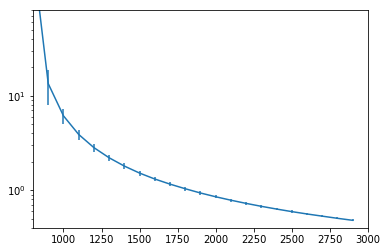

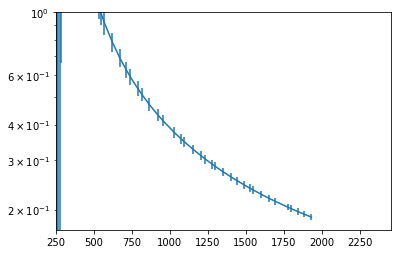

In [4]:
# %matplotlib qt

T = np.array([])
R = np.array([])

with open('ResistorCalibration.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        R = np.append(R,float(row[1]))
        T = np.append(T,float(row[0]))

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

RtoT = interp1d(R, T)

def RtoTerr(R, Rerr):
    return (RtoT(R-Rerr)-RtoT(R+Rerr))/2


v0 = np.arange(800,3000,100)


ax = plt.subplot(111)
ax.set_yscale("log", nonposy='clip')

ax.errorbar(v0, RtoT(mVtoR_He4(v0)), yerr=RtoTerr(mVtoR_He4(v0),mVtoRerr_He4(v0,4)))
plt.ylim([0.4,80])
plt.xlim([800,3000])
# plt.plot(mV4He,RtoT(mVtoRHe4(mV4He+mV4Heerr)))
# plt.plot(mV4He,RtoT(mVtoRHe4(mV4He-mV4Heerr)))
plt.show()

v0 = V_He3[3:-1]
ax = plt.subplot(111)
ax.set_yscale("log", nonposy='clip')
ax.errorbar(v0, RtoT(mVtoR_He3(v0)), yerr=RtoTerr(mVtoR_He3(v0),mVtoRerr_He3(v0,4)))
plt.ylim([0.17,1])
plt.xlim([250,2450])
# plt.plot(mV4He,RtoT(mVtoRHe4(mV4He+mV4Heerr)))
# plt.plot(mV4He,RtoT(mVtoRHe4(mV4He-mV4Heerr)))
plt.show()


Therefore calibration is given by:

In [5]:
def amVtoR_He3(V):
    return 4.648086849374947*V - 153.83061352793126

def amVtoR_He4(V):
    return 1.3432304191028368*V - 81.23102077629044

def amVtoRerr_He3(V, sigma_V):
    return V*0.083778335576055 + 59.01574424351849 + 4.648086849374947*sigma_V

def amVtoRerr_He4(V, sigma_V):
    return V*0.014020334594511486 + 22.91685849142633 + 1.3432304191028368*sigma_V



In [11]:
print(amVtoRerr_He4(100,10))
print(mVtoRerr_He4(100,10))

37.75119614190585
37.75119614190585


Live data capture!

<IPython.core.display.Javascript object>


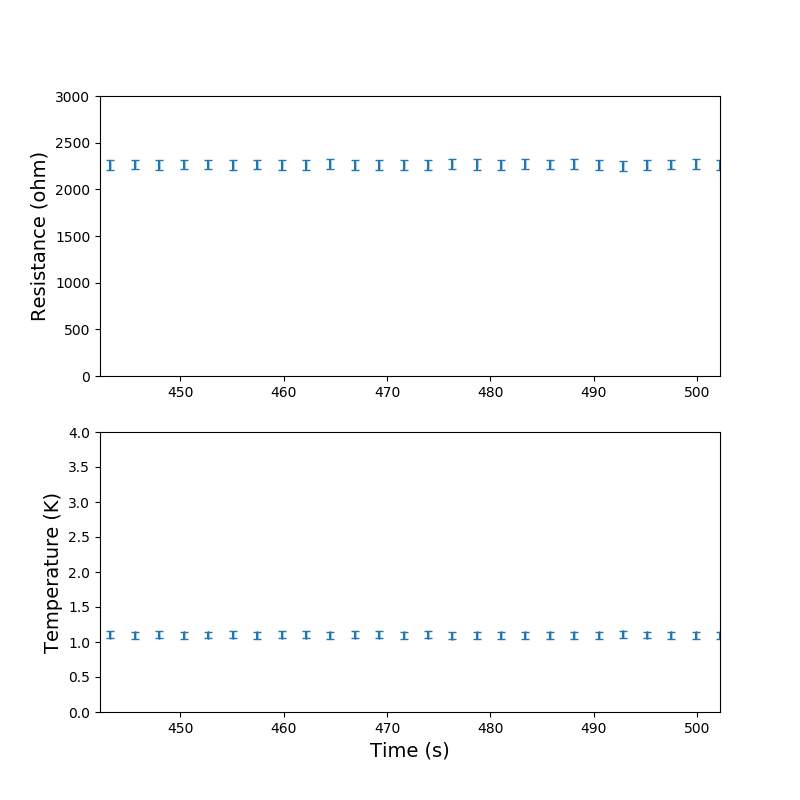

ValueError: invalid literal for int() with base 10: '89\r0'

In [36]:
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['figure.figsize'] = (8,8)

def adjustErrbarxy(errobj, x, y, x_error, y_error):
    ln, (errx_top, errx_bot, erry_top, erry_bot), (barsx, barsy) = errobj
    x_base = x
    y_base = y

    xerr_top = x_base + x_error
    xerr_bot = x_base - x_error
    yerr_top = y_base + y_error
    yerr_bot = y_base - y_error

    errx_top.set_xdata(xerr_top)
    errx_bot.set_xdata(xerr_bot)
    errx_top.set_ydata(y_base)
    errx_bot.set_ydata(y_base)

    erry_top.set_xdata(x_base)
    erry_bot.set_xdata(x_base)
    erry_top.set_ydata(yerr_top)
    erry_bot.set_ydata(yerr_bot)

    new_segments_x = [np.array([[xt, y], [xb,y]]) for xt, xb, y in zip(xerr_top, xerr_bot, y_base)]
    new_segments_y = [np.array([[x, yt], [x,yb]]) for x, yt, yb in zip(x_base, yerr_top, yerr_bot)]
    barsx.set_segments(new_segments_x)
    barsy.set_segments(new_segments_y)
    
def grab_data(numMeasurements):
    voltAlive = np.empty(numMeasurements)
    voltBlive = np.empty(numMeasurements)
    voltClive = np.empty(numMeasurements)
    voltDlive = np.empty(numMeasurements)
    voltElive = np.empty(numMeasurements)
    voltFlive = np.empty(numMeasurements)
    voltGlive = np.empty(numMeasurements)
    
    #fill arrays with data!
    for ii in np.arange(numMeasurements):  
        ser.reset_input_buffer()
        data = ser.readline() #get data
        data = list(map(int,data.decode().split(" "))) #split data into a list
        voltAlive[ii] = data[0]
        voltBlive[ii] = data[1]
        voltClive[ii] = data[2]
        voltDlive[ii] = data[3]
        voltElive[ii] = data[4]
        voltFlive[ii] = data[5]
        voltGlive[ii] = data[6]
    
    voltAlive = (voltAlive[voltAlive<1]+voltAlive[voltAlive>0])*3300.0/8191.0
    voltBlive = (voltBlive[voltBlive<1]+voltBlive[voltBlive>0])*3300.0/8191.0
    voltClive = voltClive*3300.0/8191.0
    voltDlive = voltDlive*3300.0/8191.0
    voltElive = voltElive*3300.0/8191.0
    voltFlive = voltFlive*3300.0/8191.0
    voltGlive = voltGlive*3300.0/8191.0
    
    A = np.mean(voltAlive)
    B = np.mean(voltBlive)
    C = np.mean(voltClive)
    D = np.mean(voltDlive)
    E = np.mean(voltElive)
    F = np.mean(voltFlive)
    G = np.mean(voltGlive)
    
    Aerr = np.std(voltAlive)/np.sqrt(numMeasurements)
    Berr = np.std(voltBlive)/np.sqrt(numMeasurements)
    Cerr = np.std(voltClive)/np.sqrt(numMeasurements)
    Derr = np.std(voltDlive)/np.sqrt(numMeasurements)
    Eerr = np.std(voltElive)/np.sqrt(numMeasurements)
    Ferr = np.std(voltFlive)/np.sqrt(numMeasurements)
    Gerr = np.std(voltGlive)/np.sqrt(numMeasurements)
    
    return [A, Aerr, B, Berr, C, Cerr, D, Derr, E, Eerr, F, Ferr, G, Gerr]

Rerr = np.array([])
Rdat = np.array([])
Terr = np.array([])
Tdat = np.array([])
timepoints = np.array([])

import time
%matplotlib notebook
plt.ion()
fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)

line1 = ax1.errorbar(timepoints,Rdat,0,Rerr)
line2 = ax2.errorbar(timepoints,Tdat,0,Terr)
# line1, = ax1.plot(timepoints,ydat,marker='o',markersize=4,markerfacecolor='red')
# ax1.set_xlabel('Time (s)', fontsize='14')
ax1.set_ylabel('Resistance (ohm)', fontsize='14')
ax2.set_xlabel('Time (s)', fontsize='14')
ax2.set_ylabel('Temperature (K)', fontsize='14')
Rrange = [0,3000]
Trange = [0,4]
view_time = 60 # seconds of data to view at once

ser = serial.Serial('/dev/ttyACM1', 115200)

# flush any junk left in the serial buffer
ser.flushInput()


ax1.set_ylim(Rrange)
ax1.set_xlim([0,view_time])
ax2.set_ylim(Trange)
ax2.set_xlim([0,view_time])
start_time = time.time()

while True:
    timepoints = np.append(timepoints,time.time()-start_time)
    
    #get data
    [VA, VAerr, VB, VBerr, VC, VCerr, VD, VDerr, VE, VEerr, VF, VFerr, VG, VGerr] = grab_data(100)
    
    R_He4 = mVtoR_He4(VB)
    Rerr_He4 = mVtoRerr_He4(VB,VBerr)
    T_He4 = RtoT(mVtoR_He4(VB))
    Terr_He4 = RtoTerr(mVtoR_He4(VB),mVtoRerr_He4(VB,VBerr))
    
    Rdat = np.append(Rdat,R_He4)
    Rerr = np.append(Rerr,Rerr_He4)
    Tdat = np.append(Tdat,T_He4)
    Terr = np.append(Terr,Terr_He4)
    
    adjustErrbarxy(line1,timepoints,Rdat,0,Rerr)
    adjustErrbarxy(line2,timepoints,Tdat,0,Terr)
#     line1.set_xdata(timepoints)
#     line1.set_ydata(ydat)
    
    current_time = timepoints[-1]
    if current_time > view_time:
            ax1.set_xlim([current_time-view_time,current_time])
            ax2.set_xlim([current_time-view_time,current_time])
            
    fig1.canvas.draw()

    print('The current resistance is {} +/- {}. The current temperature is {} +/- {} '.format(np.round(R_He4,0),np.round(Rerr_He4,0),np.round(T_He4,3),np.round(Terr_He4,3)), end='\r')
